In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<img src="../imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

## Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

# Step 0.0. LightAutoML installation

This step can be used if you are working inside Google Colab/Kaggle kernels or want to install LightAutoML on your machine:

In [2]:
# !pip install -U lightautoml

# Step 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [3]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

# Step 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

In [5]:
DATASET_DIR = './data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

# Step 0.3. Imported models setup

For better reproducibility we fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data loading
Let's check the data we have:

In [7]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 155 µs, sys: 112 µs, total: 267 µs
Wall time: 266 µs


In [8]:
%%time

data = pd.read_csv('./data/sampled_app_train.csv')
data.head()

CPU times: user 91.4 ms, sys: 27.6 ms, total: 119 ms
Wall time: 118 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [9]:
data.shape

(10000, 122)

# Step 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [10]:
%%time

tr_data, te_data = train_test_split(data, 
                                    test_size=TEST_SIZE, 
                                    stratify=data[TARGET_NAME], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)
CPU times: user 9.17 ms, sys: 1.97 ms, total: 11.1 ms
Wall time: 9.35 ms


In [11]:
tr_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# =========== LightAutoML model building ===========


# Step 1. Task setup

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [12]:
%%time

task = Task('binary', )

CPU times: user 5.77 ms, sys: 358 µs, total: 6.13 ms
Wall time: 5.06 ms


# Step 2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [13]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['SK_ID_CURR']
         }

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 18.1 µs


# Step 3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="../imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - we use `use_algos` key to setup the model structure to work with (Linear and LGBM model on the first level and their weighted composition creation on the second). This setup is only to speedup the kernel, you can remove this `general_params` setup if you want the whole LightAutoML model to run.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [14]:
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb'], ['linear_l2', 'lgb_tuned']]},
                       tuning_params={'max_tuning_iter': 5},
                      )

In [15]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1, log_file = 'train.log')
#print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

[13:06:19] Stdout logging level is INFO.
[13:06:19] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[13:06:19] Task: binary

[13:06:19] Start automl preset with listed constraints:
[13:06:19] - time: 300.00 seconds
[13:06:19] - CPU: 4 cores
[13:06:19] - memory: 16 GB

[13:06:19] Train data shape: (8000, 122)

[13:06:23] Layer 1 train process start. Time left 296.34 secs
[13:06:23] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:06:27] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.736918059246815
[13:06:27] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[13:06:27] Time left 292.10 secs

[13:06:30] Selector_LightGBM fitting and predicting completed
[13:06:30] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[13:06:52] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7453257333249144
[13:06:52] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[13:06:52] Time left 267.37 secs

[13:06:52] Layer 1 tr

In [16]:
%%time 

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 3)
#print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

[13:07:19] Stdout logging level is INFO3.
[13:07:19] Task: binary

[13:07:19] Start automl preset with listed constraints:
[13:07:19] - time: 300.00 seconds
[13:07:19] - CPU: 4 cores
[13:07:19] - memory: 16 GB

[13:07:19] Train data shape: (8000, 122)

[13:07:20] Feats was rejected during automatic roles guess: []
[13:07:20] Layer 1 train process start. Time left 298.86 secs
[13:07:21] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:07:21] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[13:07:21] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[13:07:22] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[13:07:23] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[13:07:23] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[13:07:24] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.736918059246815
[13:07:24] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[13:0

In [17]:
print(automl_rd.model.create_model_str_desc())

Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM

Final prediction for new objects (level 1) = 
	 0.89712 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
	 0.10288 * (5 averaged models Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM) 


# Step 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 138 ms, sys: 8.07 ms, total: 146 ms
Wall time: 144 ms


<AxesSubplot:xlabel='Feature'>

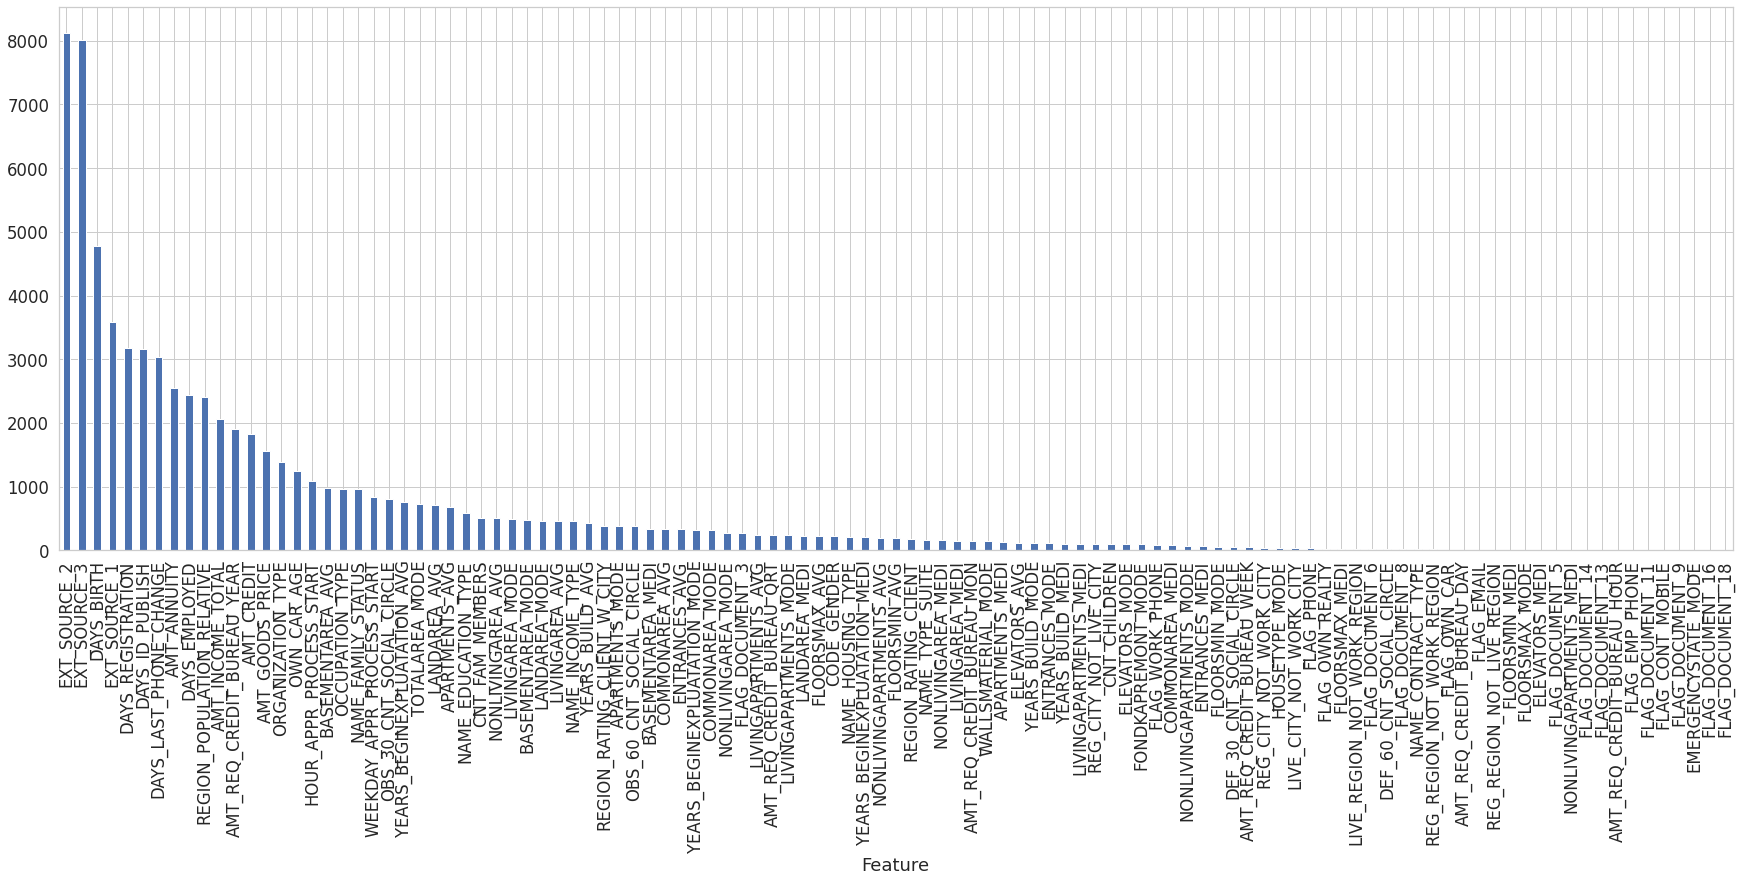

In [18]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [19]:
# %%time

# # Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
# accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

In [20]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Step 5. Prediction on holdout and metric calculation

In [21]:
%%time

te_pred = automl_rd.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[0.08925235],
       [0.14989418],
       [0.02665114],
       ...,
       [0.05207196],
       [0.0290236 ],
       [0.29689035]], dtype=float32)
Shape = (2000, 1)
CPU times: user 3.07 s, sys: 72.2 ms, total: 3.14 s
Wall time: 2.16 s


In [22]:
print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

Check scores...
OOF score: 0.7677135280702616
HOLDOUT score: 0.7241644021739131


# Bonus. Where is the automatic report?

As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output kaggle folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

# Step 6. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

Using `TabularAutoML` we spent only 31 second to build the model with setup `TIMEOUT` equal to 5 minutes. To spend (almost) all the `TIMEOUT` we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API:

In [23]:
utilized_automl = TabularUtilizedAutoML(task = task, 
                               timeout = 600,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                               general_params={'use_algos': [['linear_l2', 'lgb'], ['linear_l2', 'lgb_tuned']]},
                               tuning_params={'max_tuning_iter': 5},
                              )

In [24]:
%%time 

oof_pred = utilized_automl.fit_predict(tr_data, roles = roles, verbose = 1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

[13:08:23] Start automl utilizator with listed constraints:
[13:08:23] - time: 600.00 seconds
[13:08:23] - CPU: 4 cores
[13:08:23] - memory: 16 GB

[13:08:23] If one preset completes earlier, next preset configuration will be started

[13:08:23] ==================================================
[13:08:23] Start 0 automl preset configuration:
[13:08:23] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[13:08:23] Stdout logging level is INFO.
[13:08:23] Task: binary

[13:08:23] Start automl preset with listed constraints:
[13:08:23] - time: 600.00 seconds
[13:08:23] - CPU: 4 cores
[13:08:23] - memory: 16 GB

[13:08:23] Train data shape: (8000, 122)

[13:08:24] Layer 1 train process start. Time left 598.83 secs
[13:08:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:08:27] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.736918059246815
[13:08:27] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predictin

[13:11:13] Blending: iteration 0: score = 0.7791116273027985, weights = [0.76736534 0.23263465]
[13:11:13] Blending: iteration 1: score = 0.7791116273027985, weights = [0.76736534 0.23263465]
[13:11:13] Blending: no score update. Terminated

[13:11:13] Automl preset training completed in 64.31 seconds

[13:11:13] Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM

Final prediction for new objects (level 1) = 
	 0.76737 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
	 0.23263 * (5 averaged models Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM) 

[13:11:13] ==================================================
[13:11:13] Start 3 automl preset configuration:
[13:11:13] conf_3_sel_type_1_no_inter_lgbm.yml, random state: {'reader_params': {'random_state': 45}, 'general_params': {'return_all_predictions': False}}
[13:11:13] Stdout logging level is INFO.
[13:11:13] Task: binary

[13:11:13] Start automl preset with listed 

[13:13:39] Start fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM ...
[13:14:03] Fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM finished. score = 0.6748648238963586
[13:14:03] Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM fitting and predicting completed
[13:14:03] Start fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM ...
[13:14:31] Fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM finished. score = 0.7178410771653423
[13:14:31] Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM fitting and predicting completed
[13:14:31] Start fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM ...
[13:14:47] Fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM finished. score = 0.7315339758516685
[13:14:47] Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM fitting and predicting completed
[13:14:47] Start fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM ...
[13:15:16] Fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM finished. score = 0.72344839007934
[13:15:16] Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM fitting and predicting completed
[13:15:16] Start fitting Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM ...
[13:15:50] Fitt

[13:18:01] ==================================================
[13:18:01] Blending: optimization starts with equal weights and score 0.7985247292597986
[13:18:01] Blending: iteration 0: score = 0.8045819028041667, weights = [0.         0.28896195 0.11513317 0.         0.253581   0.15902662
 0.1832973 ]
[13:18:01] Blending: iteration 1: score = 0.804656100044242, weights = [0.         0.27426797 0.07869788 0.         0.28295976 0.1691308
 0.19494358]
[13:18:01] Blending: iteration 2: score = 0.804656100044242, weights = [0.         0.27426797 0.07869788 0.         0.28295976 0.1691308
 0.19494358]
[13:18:01] Blending: no score update. Terminated

oof_pred:
array([[0.03121657],
       [0.0188658 ],
       [0.02296075],
       ...,
       [0.03195725],
       [0.18878189],
       [0.12279522]], dtype=float32)
Shape = (8000, 1)
CPU times: user 36min 42s, sys: 27.5 s, total: 37min 9s
Wall time: 9min 38s


In [25]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.27427 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM

		Final prediction for new objects (level 1) = 
			 1.00000 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 


	+ 0.07870 * 1 averaged models with config = "conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM

		Final prediction for new objects (level 1) = 
			 0.76737 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
			 0.23263 * (5 averaged models Lvl_1_Pipe_1_Mod_0_Tuned_LightGBM) 


	+ 0.28296 * 1 averaged models with config = "conf_4_sel_type_0_no_int.yml" and different CV random_states. Their structures: 

	    Model #0.
	

# Step 7. Feature importances calculation for `TabularUtilizedAutoML`

CPU times: user 153 ms, sys: 8.02 ms, total: 161 ms
Wall time: 159 ms


<AxesSubplot:xlabel='Feature'>

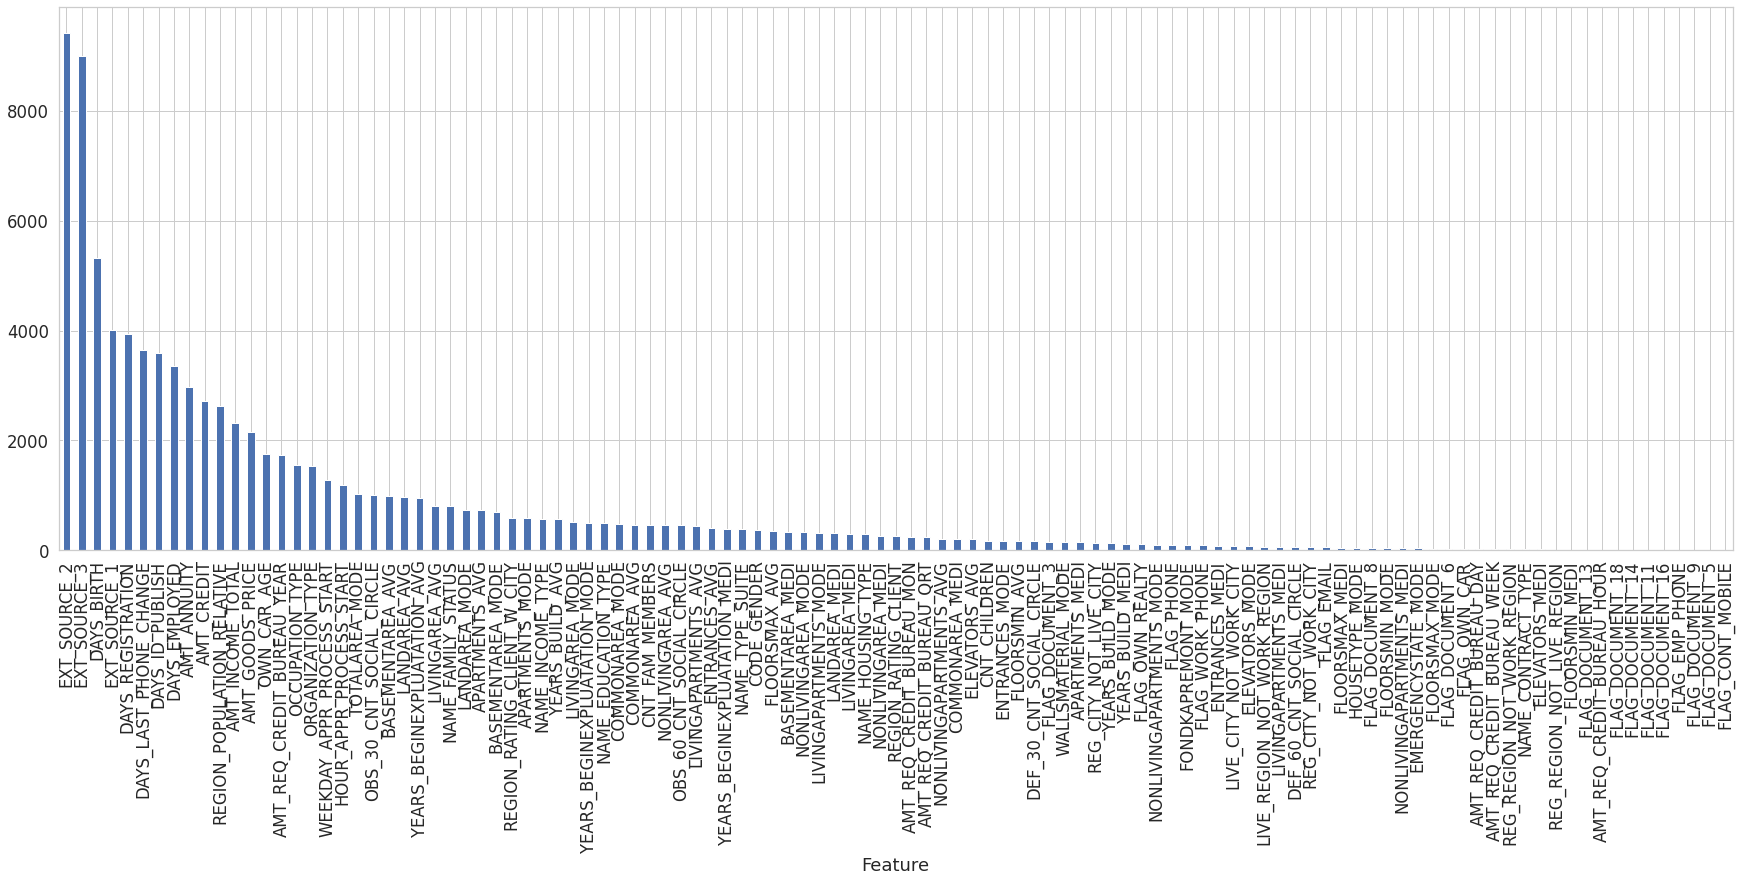

In [26]:
%%time

# Fast feature importances calculation
fast_fi = utilized_automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Step 8. Prediction on holdout and metric calculation

In [27]:
%%time

te_pred = utilized_automl.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[0.07261931],
       [0.09788669],
       [0.02807039],
       ...,
       [0.04051852],
       [0.02296177],
       [0.25143594]], dtype=float32)
Shape = (2000, 1)
CPU times: user 6.11 s, sys: 104 ms, total: 6.21 s
Wall time: 2.26 s


In [28]:
print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

Check scores...
OOF score: 0.8046582260396596
HOLDOUT score: 0.7214673913043479


# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)